# **Airbus Ship Detection Challenge**
# Import, Datasets, Constants

In [ ]:
# IMPORTS
import os
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


# CONSTANTS
ROOT_PATH = '/kaggle/input/airbus-ship-detection/'

SIZE_FULL = 768

TRAIN_FOLDER = ROOT_PATH + 'train_v2'
SAMPLE_FOLDER = ROOT_PATH + 'test_v2'

BLEND_ALPHA = 0.6


# LOADING DATASETS
train_set = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')
sample_set = pd.read_csv('/kaggle/input/airbus-ship-detection/sample_submission_v2.csv')

## RLE Decoder

First of all, we will need to decode our masks from the .csv file to work with them.

In [6]:
# https://www.kaggle.com/code/stainsby/fast-tested-rle/notebook
## Decoding RLE masks to NP arrays where 1 - ship, 0 - no ship
def decode(mask_rle: np.ndarray) -> np.ndarray:
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    img=np.zeros(SIZE_FULL*SIZE_FULL, dtype=np.float32)
    if not(type(mask_rle) is float):
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1.0
    return img.reshape((SIZE_FULL, SIZE_FULL)).T

# EDA
## CSV Contents

In [3]:
# Checking the content of train set
train_set

ImageId                                      EncodedPixels
0       00003e153.jpg                                                NaN
1       0001124c7.jpg                                                NaN
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...               ...                                                ...
231718  fffedbb6b.jpg                                                NaN
231719  ffff2aa57.jpg                                                NaN
231720  ffff6e525.jpg                                                NaN
231721  ffffc50b4.jpg                                                NaN
231722  ffffe97f3.jpg                                                NaN

[231723 rows x 2 columns]

The training dataset has two columns:

- 'ImageId' is the name of the file.
- 'EncodedPixels' is the mask for the single ship on the photo.

The fact that each row equals 1 single ship (in addition to common practices) could be seen with rows 3 and 4: we see the same 'ImageId'.

In [4]:
# Checking the content of sample set
sample_set

ImageId EncodedPixels
0      00002bd58.jpg           1 2
1      00015efb6.jpg           1 2
2      00023d5fc.jpg           1 2
3      000367c13.jpg           1 2
4      0008ca6e9.jpg           1 2
...              ...           ...
15601  ffdb3cda6.jpg           1 2
15602  ffe3857eb.jpg           1 2
15603  ffeb765e8.jpg           1 2
15604  ffeba1475.jpg           1 2
15605  fff0fd44f.jpg           1 2

[15606 rows x 2 columns]

The sample dataset has the same structure but 'EncodedPixels' values filled with dummies that are yet to be replaced with our own results.

## CSV Datatypes

In [5]:
# Checking info about train set
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [6]:
# Checking info about sample set
sample_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15606 entries, 0 to 15605
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        15606 non-null  object
 1   EncodedPixels  15606 non-null  object
dtypes: object(2)
memory usage: 244.0+ KB


## Quantities

In [7]:
# Checking the quantity of our test images in the 'train_v2' folder
files = os.listdir(TRAIN_FOLDER)
num_files = len(files)
print(num_files)

192556


In [8]:
# Checking the quantity of unique images with masks (ships)
unique_files = train_set.drop_duplicates(subset=['ImageId'])
num_unique_files = unique_files.dropna(subset=['EncodedPixels'])
print(len(num_unique_files))

42556


## Visual Analysis of the Original Images

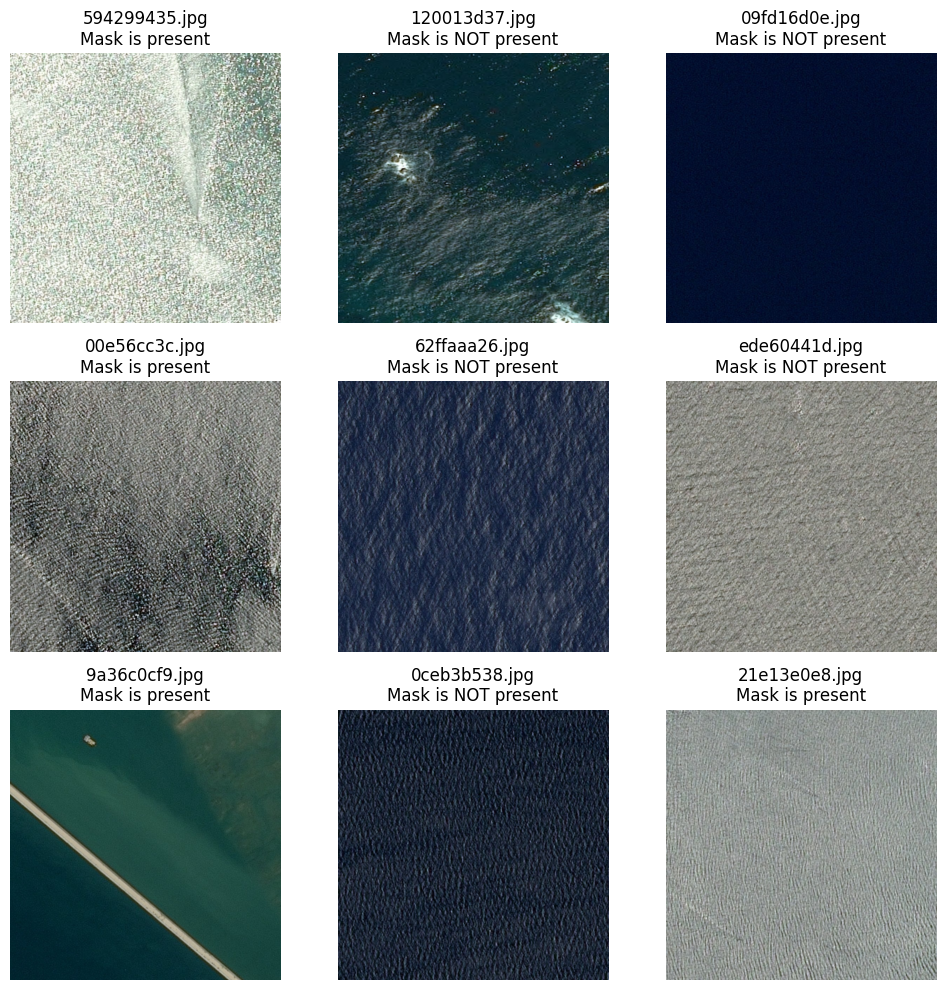

In [9]:
## Showing 9 original random images with mask labels

def plot_image_with_mask(image_id: str, encoded_pixels: pd.Series) -> None:
    '''
    Find and display the image with label
    image_id: str - name of the file
    encoded_pixels: pd.Series - value with the mask
    Returns None
    '''
    # Uploading the image
    image = Image.open(TRAIN_FOLDER + '/' + image_id)
    # Filling the plot
    plt.subplot(3, 3, i+1)  # defining 3x3 structure for the plot
    plt.imshow(image)  # displaying image
    if not pd.isnull(encoded_pixels):
        plt.title(f'{image_id}\nMask is present')  # label with mask
    else:
        plt.title(f'{image_id}\nMask is NOT present')  # label w/o mask
    plt.axis('off')  # disabling axis

def get_random_images() -> tuple[str, pd.Series]:
    '''
    Gets random original image and its single mask (if any)
    Returns image_id (str), encoded_pixels (pd.Series)
    '''
    image_id = train_set['ImageId'].sample().iloc[0]  # selecting random imageId from .csv
    encoded_pixels = train_set.loc[train_set['ImageId'] == image_id, 'EncodedPixels'].iloc[0]  # recieving mask of the ImageId from .csv
    return image_id, encoded_pixels


# Creating a plot
plt.figure(figsize=(10, 10))
for i in range(9):
    image_id, encoded_pixels = get_random_images() # Get random image and its mask
    plot_image_with_mask(image_id, encoded_pixels) # Display the image

# Displaying the plot
plt.tight_layout()
plt.show()

## Visual Analysis of the Masks (Blended with the Original Images)

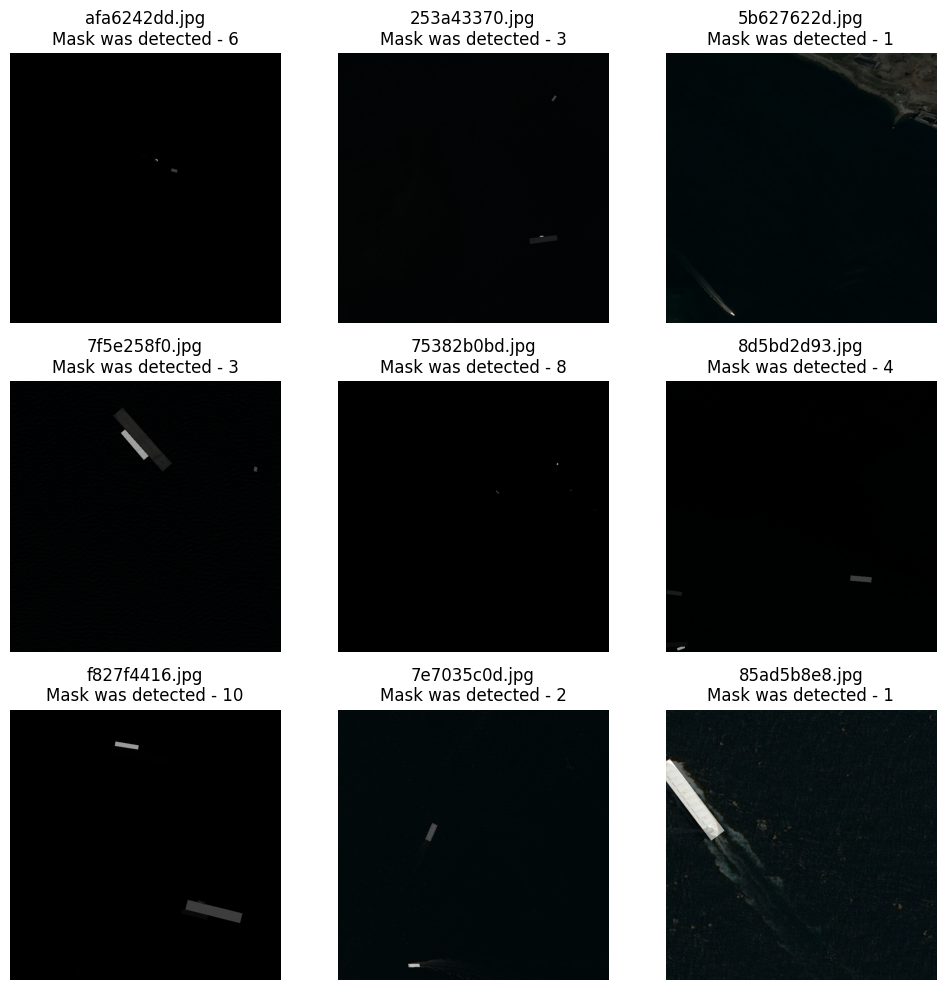

In [10]:
## Showing 9 original random images with multiple mask overlays (if not single) and the quantity of detected ships


def get_sample_overlay_output(image_id: Image.Image, mask: pd.Series) -> Image.Image:
    """
    Returns the original image blended with single mask
    image_id: Image.Image - original image
    mask: pd.Series - a value with a single mask for the original image
    Returns blended image (Image.Image)
    """
    decoded_mask = decode(mask) # Decoding RLE mask
    mask_image = Image.fromarray((decoded_mask * 255).astype(np.uint8)) # Creating PIL Image from the NP array
    result_image = Image.blend(image_id, mask_image.convert('RGBA'), alpha=BLEND_ALPHA) # Blending original image with decoded mask
    return result_image

def plot_image_with_mask_blended(image: Image.Image, encoded_pixels: pd.DataFrame, masks_quantity: int) -> None:
    '''
    Displaying image, its mask and ships quantity
    image: Image.Image - result image
    encoded_pixels: pd.DataFrame - masks for the image
    masks_quantity: int - number of masks for the image
    Return none
    '''
    # Defining a plot
    plt.subplot(3, 3, i+1)  # Defining 3x3 structure
    plt.imshow(image)  # Displaying the image
    # Adding a label
    if not pd.isnull(encoded_pixels).any():
        plt.title(f'{image_id_str}\nMask was detected - {masks_quantity}')  # Mask(s) is/are present
    else:
        plt.title(f'{image_id_str}\nMask was NOT detected')  # Mask(s) is/are not present
    plt.axis('off')  # Disabling axis

def get_random_images_masked():
    '''
    Getting random images with masks
    Returns image_id (pd.Series), image_id_str (str), encoded_pixels (pd.DataFrame)
    '''
    image_id = train_set[~train_set["EncodedPixels"].isna()].sample() # Retting random image with mask
    image_id_str = str(image_id.values[0][0]) # Retrieving the name of it
    encoded_pixels = train_set.loc[train_set['ImageId'] == image_id_str, 'EncodedPixels']  # Retrieving its mask(s)
    return image_id, image_id_str, encoded_pixels


# Creating a plot
plt.figure(figsize=(10, 10))
samples = [] # These will be passed to the function in the next comparison section
for i in range(9):
    image_id, image_id_str, encoded_pixels = get_random_images_masked() # Getting random images with masks
    if not pd.isnull(encoded_pixels).any():
        original_image_name = Path(TRAIN_FOLDER) / image_id_str # Upload the original name of the image
        original_image = Image.open(original_image_name)  # Converting it to PIL Image
        original_image = original_image.convert('RGBA') # Converting it to RGBA for blending compatability
        blended_image = original_image
        masks_quantity = len(encoded_pixels)
        for mask_number in range(len(encoded_pixels)):
            # Looping through each detected mask
            mask = encoded_pixels.iloc[mask_number] # Extracting current mask
            blended_image = get_sample_overlay_output(blended_image, mask) # Blending each mask with the original image

    plot_image_with_mask_blended(blended_image, encoded_pixels, masks_quantity) # Display the image
    samples.append((blended_image, original_image)) # Add the original and blended image for the next comparison section

# Displaying the plot
plt.tight_layout()
plt.show()

## Side-by-side Comparison of the Original and Blended Images

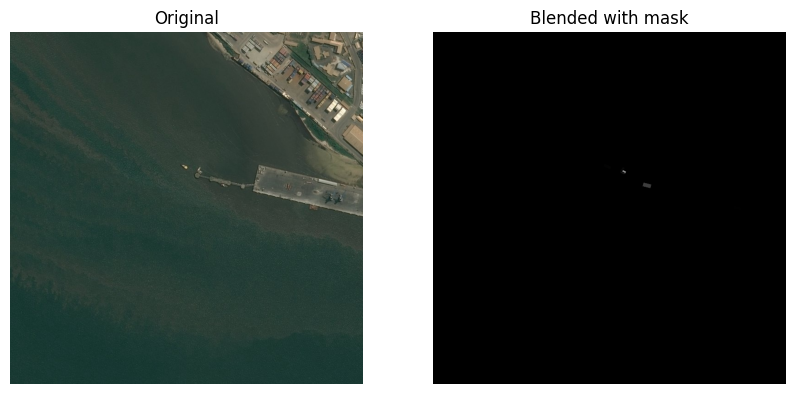

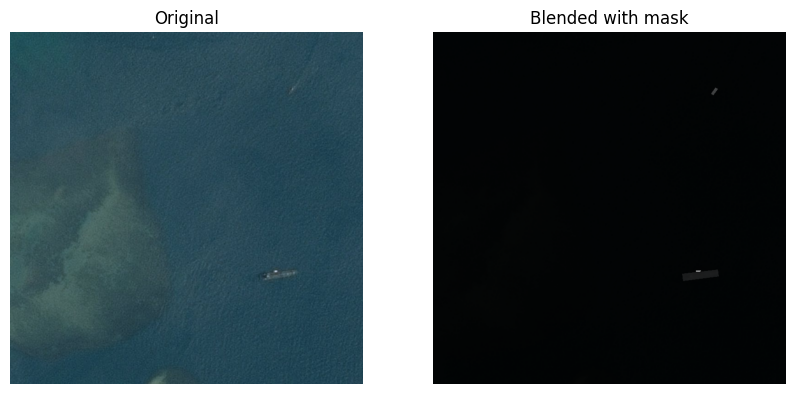

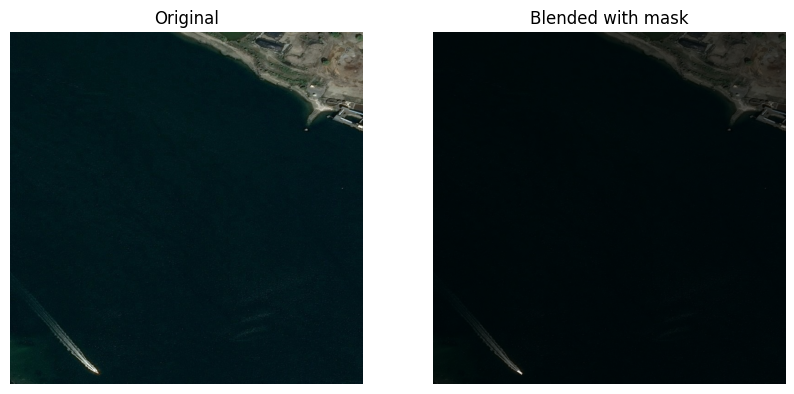

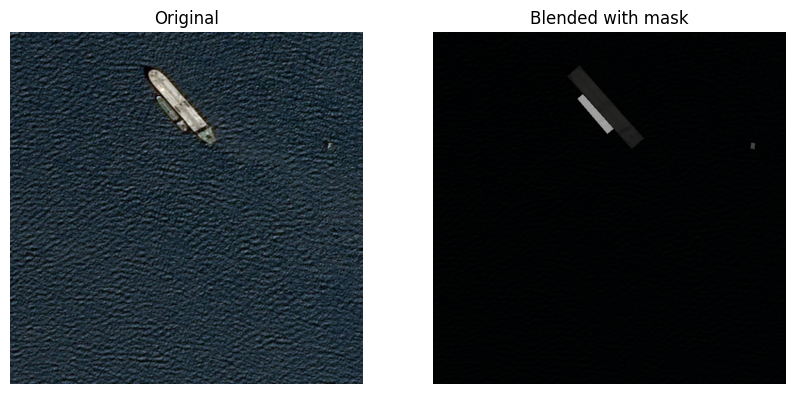

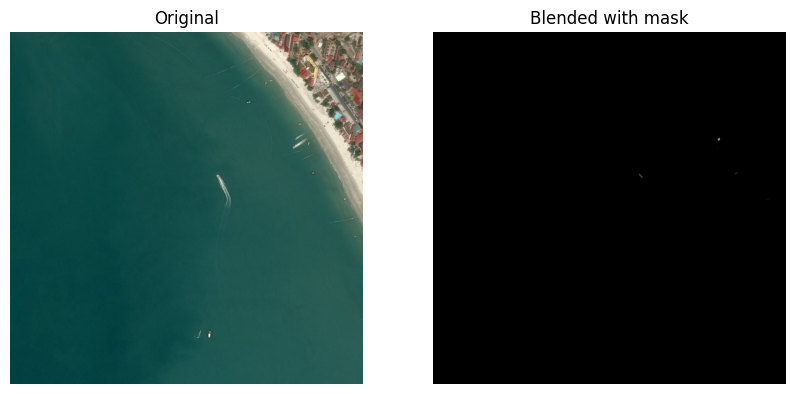

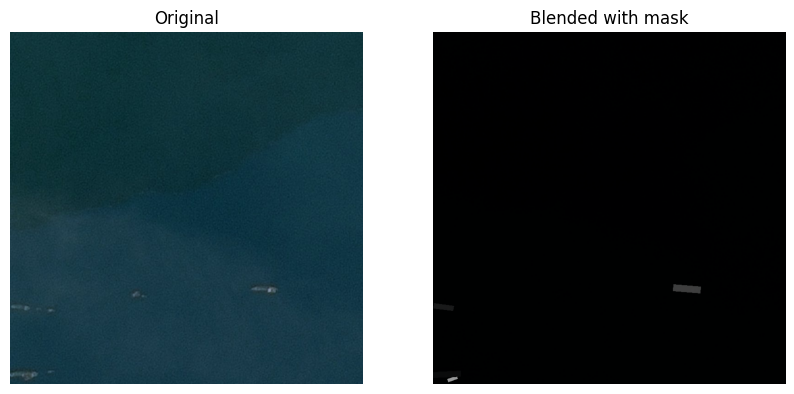

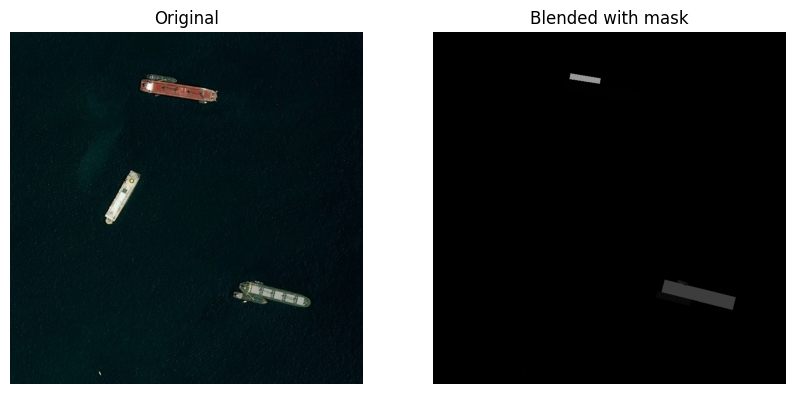

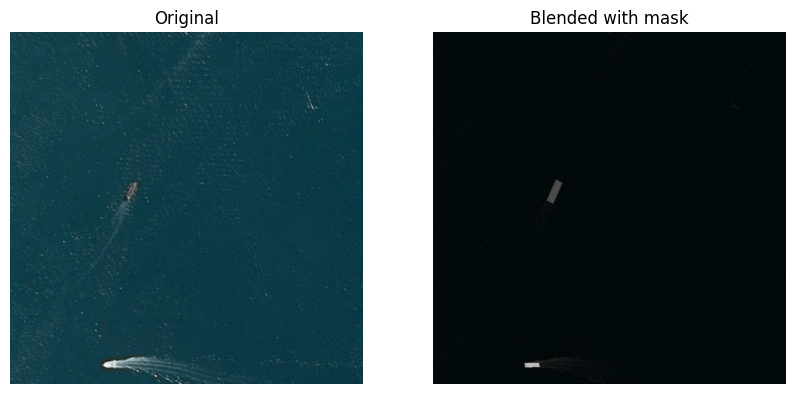

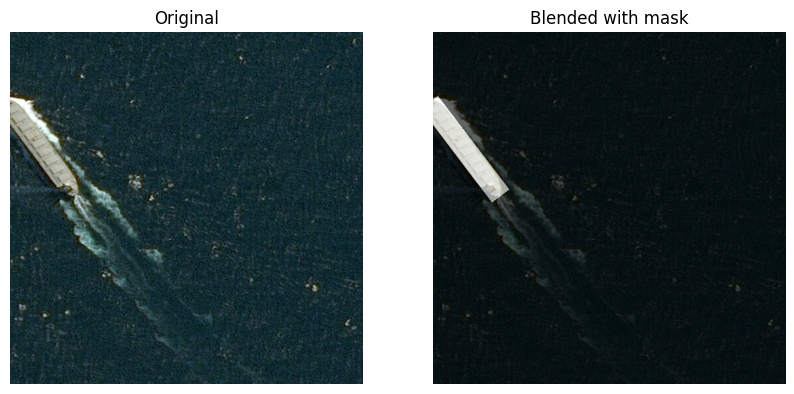

In [11]:
# Display original image together with a blended (with masks) image for visual comparison

def visualize_segmentation(image: Image.Image, mask: Image.Image) -> None:
    '''
    Display a single pair of original and same blended with its masks image
    image: Image.Image - original image
    mask: Image.Image - blended image
    Returns none
    '''
    plt.figure(figsize=(10, 5))
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')
    # Blended image
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Blended with mask')
    plt.axis('off')
    plt.show()


# Displaying each of pairs from the previously created (in the section above) set
for element in samples:
    visualize_segmentation(element[1], element[0]) # Display the pair

# Checking data integrity
## Image Validation
### Size check

In [ ]:
# Check if all of the images have the same size (and what sizes if not)

image_folder = TRAIN_FOLDER
image_sizes = set() # set for sizes

# Loop through all the images
for filename in os.listdir(image_folder):
    image_path = os.path.join(image_folder, filename) # Image path
    image = cv2.imread(image_path) # Reading the image
    height, width, _ = image.shape # Getting its shape
    image_sizes.add((width, height)) # Adding current image size to the set

# Print image sizes
print("Image sizes:")
for size in image_sizes:
    print(size)

# Checking
if len(image_sizes) == 1:
    print("Every images are the same size.")
else:
    print("There are different image sizes.")

Premature end of JPEG file


In [ ]:
# Folder with the images
image_folder = SAMPLE_FOLDER

# List for storing the sizes
image_sizes = []

# Loop through each of the images
for filename in os.listdir(image_folder):
    # Getting the path to the image
    image_path = os.path.join(image_folder, filename)
    # Uploading the image
    image = cv2.imread(image_path)
    # Get sizes
    height, width, _ = image.shape
    # Add sizes to the list
    image_sizes.append((width, height))


print(image_sizes[0])

# Checking sizes to be equal
if len(set(image_sizes)) == 1:
    print("Every images are the same size.")
else:
    print("There are different image sizes.")

## Checking for errors

In [ ]:
# Validate (check for IO errors) all the images in the train and sample sets

def is_valid_image(file_path: str) -> bool:
    '''
    Check the single image
    file_path: str - path to the file
    Returns if image is valid (bool)
    '''
    try:
        with open(file_path, 'rb') as f:
            img = Image.open(f) # Reading the file
            img.verify() # Verify that it is, in fact an image
        return True
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return False

def filter_valid_files(directory: str) -> tuple[list, int]:
    '''
    Loop through the directory, check each image and count the files
    directory: str - the target folder
    Returns invalid_files (list), count (int)
    '''
    invalid_files = [] # list of bad files
    count = 0
    # Looping through each file
    for filename in os.listdir(directory):
        count += 1
        file_path = os.path.join(directory, filename) # Getting path to the file
        # Validation
        if not is_valid_image(file_path):
            invalid_files.append(file_path) # Adding the bad file to the list
        else:
            if count % 10000 == 0:
                print('Current count is: ', count) # Prints when each 10k files are checked
    return invalid_files, count


# Check the images for train set
data_directory = TRAIN_FOLDER
invalid_files, count = filter_valid_files(data_directory)
print(invalid_files, count)

# Check the images for sample set
data_directory = SAMPLE_FOLDER
invalid_files, count = filter_valid_files(data_directory)
print(invalid_files, count)

# Results

### Datatypes

Our analysis shows that columns have np 'object type which should not be an issue.
In NumPy, 'NaN' is a float.
Values with masks have a 'string' type.


### Image Quantity:

1. **Train set:**
- Total images - 192 556
- Total rows (empty, single mask, multiple mask) - 231 723
- Total masks (single, multiple masks) - 81 723
- Total unique images with masks (multiple masks do not count) - 42 556
- Without ships (w/o masks) - 150 000

2. **Sample set:**

Total images - 15 606

3. **Total number:** 208 162


As we can see, there are 42556 images with 81723 ships on them.
It means that roughly 1/4 of the dataset has masks (with ships).

All of the images have the same 768x768 size and 'JPG' format.


### Visual analysis:

By running the code a few times, we can learn that some images seem to not detect a few ships. However, false positives are not present or rare.


### Data integrity:

The training dataset has no errors, all images have the same (768x768) shape.